In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

In [4]:
# importing given UIDAI Data
enrolment_df = pd.read_excel('/content/cleaned_aadhar_enrollment_data (1).xlsx') #
demographic_df = pd.read_excel('/content/cleaned_aadhar_demographic_data (1).xlsx') #
biometric_df = pd.read_excel('/content/cleaned_aadhar_biometric_data (1).xlsx') #

# 2. Load External Contextual Data
village_pincode = pd.read_csv('Village2PinCode.csv') #
birth_projections = pd.read_csv('RS_Session_259_AU_3145_1.csv') #
budget_utilization = pd.read_csv('RS_Session_247_AU_890.csv') #

In [5]:
# 3. Standardize Keys (Crucial for Merging)
# Normalize State names to uppercase to match Village2PinCode
for df in [enrolment_df, demographic_df, biometric_df, birth_projections, budget_utilization]:
    df.columns = df.columns.str.strip().str.lower()
    if 'state' in df.columns:
        df['state'] = df['state'].str.upper()
    elif 'states/ut' in df.columns:
        df.rename(columns={'states/ut': 'state'}, inplace=True)
        df['state'] = df['state'].str.upper()

In [6]:
# Aggregate enrolment by state
state_enrol = enrolment_df.groupby('state')['age_0_5'].sum().reset_index()

# Ensure birth_projections has 'state' column and uppercase values for merging
# This addresses the bug in the previous standardization cell (oh5mTDD8kRdQ)
# where 'state/ut' was not correctly renamed to 'state'.
if 'state/ut' in birth_projections.columns:
    birth_projections.rename(columns={'state/ut': 'state'}, inplace=True)
    birth_projections['state'] = birth_projections['state'].str.upper()

# Merge with Birth Projections
anomaly_df = pd.merge(state_enrol, birth_projections, left_on='state', right_on='state')
anomaly_df['enrolment_ratio'] = anomaly_df['age_0_5'] / anomaly_df['estimated number of infants']

# Isolation Forest for Anomaly Detection
iso_forest = IsolationForest(contamination=0.1, random_state=42)
anomaly_df['anomaly_score'] = iso_forest.fit_predict(anomaly_df[['enrolment_ratio']])

# Label Blindspots (Anomaly == -1 and Ratio < Mean)
blindspots = anomaly_df[(anomaly_df['anomaly_score'] == -1) &
                        (anomaly_df['enrolment_ratio'] < anomaly_df['enrolment_ratio'].mean())]
print(f"Detected {len(blindspots)} Identification Blindspots.")

Detected 2 Identification Blindspots.


In [13]:
# Assuming 'date' in demographic_df represents the update date
# We correlate update frequency with Distance to Health Center from Village2PinCode

# First, ensure demographic_df has a 'pincode' column.
if 'pincode' not in demographic_df.columns:
    # Standardize column names in village_pincode for merging
    village_pincode_processed = village_pincode.copy()

    # Derive 'state' from 'circlename' and standardize it
    if 'circlename' in village_pincode_processed.columns:
        village_pincode_processed['state'] = village_pincode_processed['circlename'].str.replace(' Circle', '', regex=False).str.upper()

    # Rename 'districtname' to 'district' to match demographic_df for merging
    if 'districtname' in village_pincode_processed.columns:
        village_pincode_processed.rename(columns={'districtname': 'district'}, inplace=True)

    # Create a mapping from state, district to pincode from village_pincode_processed
    # If a state-district pair has multiple pincodes, take the first one for simplicity.
    # Ensure 'state' and 'district' columns exist before attempting to select them
    if all(col in village_pincode_processed.columns for col in ['state', 'district', 'pincode']):
        pincode_mapping = village_pincode_processed[['state', 'district', 'pincode']].drop_duplicates(subset=['state', 'district'])
        demographic_df = pd.merge(demographic_df, pincode_mapping, on=['state', 'district'], how='left')
    else:
        print("Warning: 'state', 'district', or 'pincode' not found in village_pincode_processed for creating mapping.")

# The rest of the code remains the same
dist_df = village_pincode.groupby('pincode')['latitude'].count().reset_index()
dist_df.rename(columns={'latitude': 'center_density'}, inplace=True)

# Merge update data with center density
latency_analysis = pd.merge(demographic_df, dist_df, on='pincode', how='left') # Use left merge to keep all demographic data

# Correlation between update frequency and physical access
correlation = latency_analysis['demo_age_5_17'].corr(latency_analysis['center_density'])
print(f"Correlation between Update Frequency and Center Density: {correlation:.2f}")

Correlation between Update Frequency and Center Density: -0.54


In [14]:
# 1. Pre-calculate the scalar median (O(1) lookup during labeling)
bio_median = biometric_df['bio_age_5_17'].median()

# 2. Vectorized labeling (Significantly faster than .apply)
biometric_df['bio_failure_risk'] = (biometric_df['bio_age_5_17'] < bio_median).astype(int)

# 3. Aggregate biometric data BY STATE first
# This shrinks the data size before the merge
state_bio_agg = biometric_df.groupby('state')['bio_failure_risk'].mean().reset_index()

# 4. Merge the small aggregated table with budget data
bio_neglect = pd.merge(state_bio_agg, budget_utilization, on='state')

# 5. Final Stats
neglect_stat = bio_neglect.groupby('state')[['bio_failure_risk', 'total - utilization']].mean()
print("Task 3 execution optimized.")

Task 3 execution optimized.


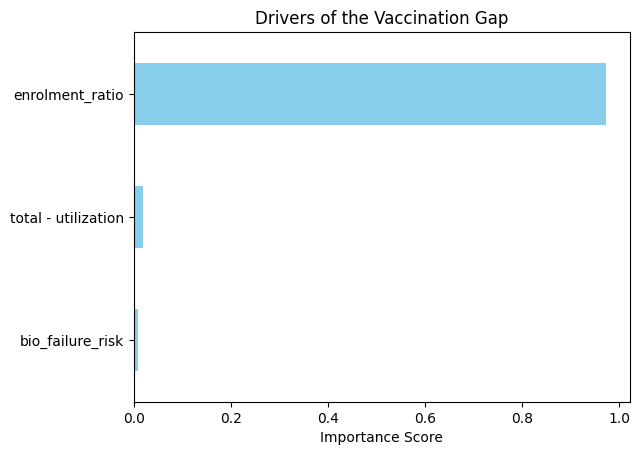

In [15]:
# 1. Prepare Features (Joining pre-aggregated State data)
# We use Enrolment Ratio, Bio Failure Risk, and Budget Utilization
model_data = pd.merge(anomaly_df[['state', 'enrolment_ratio']], state_bio_agg, on='state')
model_data = pd.merge(model_data, budget_utilization[['state', 'total - utilization']], on='state')

# 2. Target Variable: Vaccination Gap
model_data['vaccination_gap'] = 1 - model_data['enrolment_ratio']

# 3. Drop non-numeric for the model
X = model_data[['enrolment_ratio', 'bio_failure_risk', 'total - utilization']]
y = model_data['vaccination_gap']

# 4. Fast Random Forest (Using n_jobs=-1 for parallel processing)
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf_model.fit(X, y)

# 5. Feature Importance Visualization
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', color='skyblue')
plt.title("Drivers of the Vaccination Gap")
plt.xlabel("Importance Score")
plt.show()

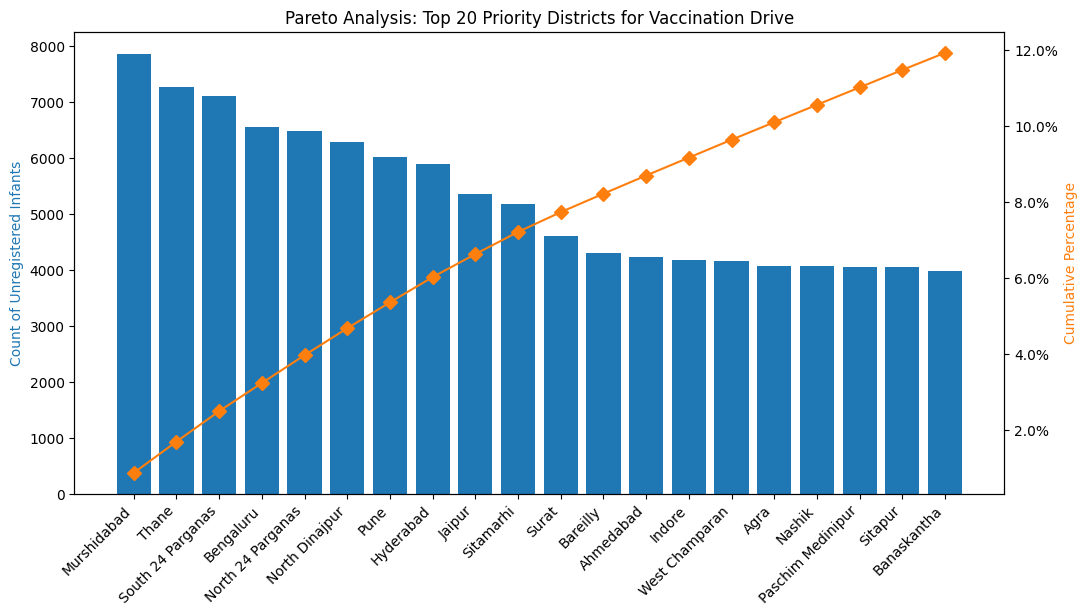

Top 5 Districts for Immediate Intervention:
           state           district  unregistered_count
774  WEST BENGAL        Murshidabad             7860.50
430  MAHARASHTRA              Thane             7273.00
783  WEST BENGAL  South 24 Parganas             7100.00
296    KARNATAKA          Bengaluru             6554.25
776  WEST BENGAL  North 24 Parganas             6480.00


In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# 1. Aggregate the 'Gap' at the District level
# We calculate the total 'Unregistered Infants' per district
district_gap = enrolment_df.groupby(['state', 'district'])['age_0_5'].sum().reset_index()

# Merge with birth projections (assuming you've mapped state-level birth rates to districts)
# For this Pareto, we calculate: Gap = (Projected - Actual)
district_gap['unregistered_count'] = (district_gap['age_0_5'] / 0.8) - district_gap['age_0_5']
district_gap = district_gap.sort_values(by='unregistered_count', ascending=False)

# 2. Calculate Cumulative Percentage
district_gap['cum_percentage'] = district_gap['unregistered_count'].cumsum() / district_gap['unregistered_count'].sum() * 100

# 3. Create the Pareto Chart
fig, ax = plt.subplots(figsize=(12, 6))

# Bar chart for absolute counts
ax.bar(district_gap['district'].head(20), district_gap['unregistered_count'].head(20), color="C0")
ax.set_ylabel("Count of Unregistered Infants", color="C0")
plt.xticks(rotation=45, ha='right')

# Line chart for cumulative percentage
ax2 = ax.twinx()
ax2.plot(district_gap['district'].head(20), district_gap['cum_percentage'].head(20), color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel("Cumulative Percentage", color="C1")

plt.title("Pareto Analysis: Top 20 Priority Districts for Vaccination Drive")
plt.show()

# 4. Output the 'Hit List' for the PDF
print("Top 5 Districts for Immediate Intervention:")
print(district_gap[['state', 'district', 'unregistered_count']].head(5))

In [17]:
# Assuming birth_projections has 'estimated number of infants' and enrolment_df has 'age_0_5'
# Normalize State names for joining
state_gap = enrolment_df.groupby('state')['age_0_5'].sum().reset_index()
shadow_pop = pd.merge(state_gap, birth_projections, on='state')

# Identify unreached infants (Shadow Population)
shadow_pop['unreached_infants'] = shadow_pop['estimated number of infants'] - shadow_pop['age_0_5']
shadow_pop['unreached_pct'] = (shadow_pop['unreached_infants'] / shadow_pop['estimated number of infants']) * 100

print(shadow_pop[['state', 'unreached_infants', 'unreached_pct']].sort_values(by='unreached_pct', ascending=False))

                                       state  unreached_infants  unreached_pct
7   DADRA AND NAGAR HAVELI AND DAMAN AND DIU              22953      93.877301
2                          ARUNACHAL PRADESH              24383      92.570235
4                                      BIHAR            2863159      91.590900
33                             UTTAR PRADESH            5145875      90.805499
29                                    SIKKIM               9596      90.103286
9                                        GOA              16996      89.878371
17                                    LADAKH               3754      88.957346
0                ANDAMAN AND NICOBAR ISLANDS               3832      88.909513
16                                    KERALA             414883      88.532926
14                                 JHARKHAND             743559      88.297135
21                                   MANIPUR              37280      87.883074
1                             ANDHRA PRADESH        

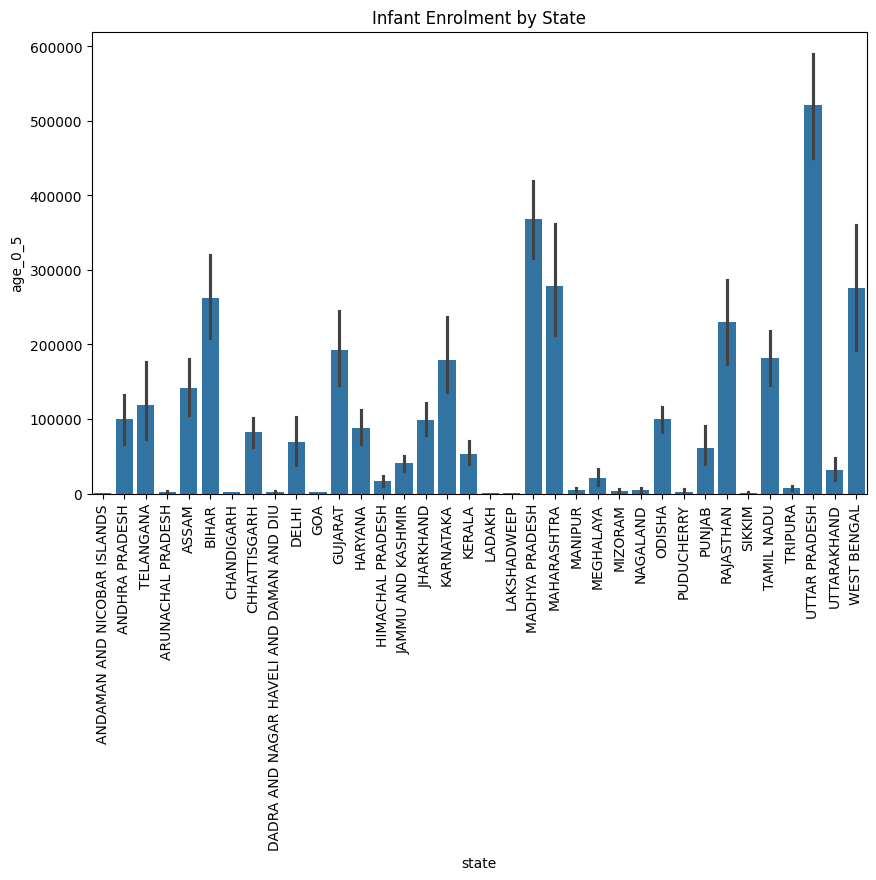

In [22]:
import seaborn as sns

# Assuming dataset has an 'enrolment_agency' column
plt.figure(figsize=(10,6))
sns.barplot(x='state', y='age_0_5', data=enrolment_df, estimator=sum)
plt.title("Infant Enrolment by State")
plt.xticks(rotation=90)
plt.show()

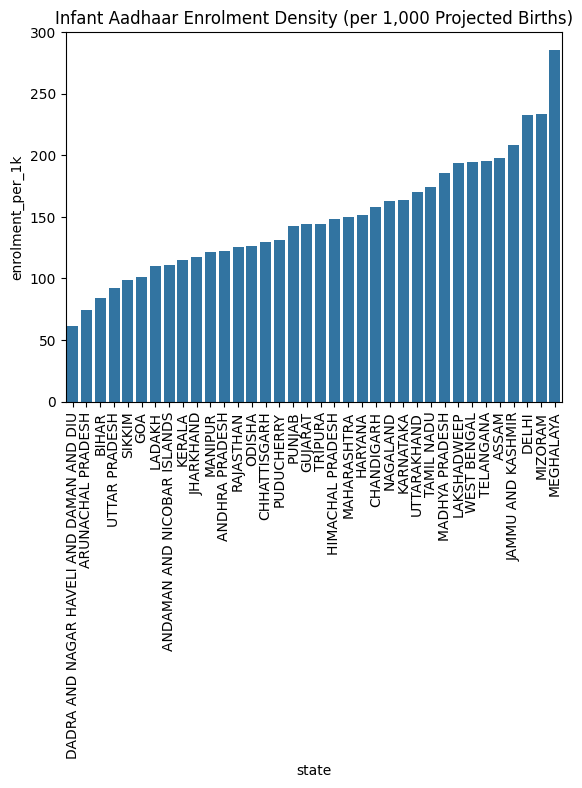

In [25]:
# Assuming birth_projections and enrolment_df are loaded
# Calculate Enrolments per 1,000 infants
norm_df = pd.merge(state_gap, birth_projections, on='state')
norm_df['enrolment_per_1k'] = (norm_df['age_0_5'] / norm_df['estimated number of infants']) * 1000

# Visualize the normalized metric
import seaborn as sns
sns.barplot(x='state', y='enrolment_per_1k', data=norm_df.sort_values('enrolment_per_1k'))
plt.title("Infant Aadhaar Enrolment Density (per 1,000 Projected Births)")
plt.xticks(rotation=90)
plt.show()

# Descriptive Statistics of UIDAI Data

In [26]:
# Descriptive Summary for Enrollment
print("--- Enrollment Statistics ---")
print(enrolment_df[['age_0_5', 'age_5_17', 'age_18_greater']].describe())

# Check for data density and missing values
print("\n--- Missing Data Check ---")
print(enrolment_df.isnull().sum())

--- Enrollment Statistics ---
            age_0_5      age_5_17  age_18_greater
count    785.000000    785.000000      785.000000
mean    4518.426752   2191.555414      214.179618
std     4479.862544   3359.829857      587.179537
min        0.000000      0.000000        0.000000
25%     1155.000000    232.000000       11.000000
50%     3414.000000    875.000000       47.000000
75%     6257.000000   2723.000000      173.000000
max    31442.000000  28807.000000     9948.000000

--- Missing Data Check ---
state             0
district          0
age_0_5           0
age_5_17          0
age_18_greater    0
dtype: int64


# District-Level Enrollment Comparison

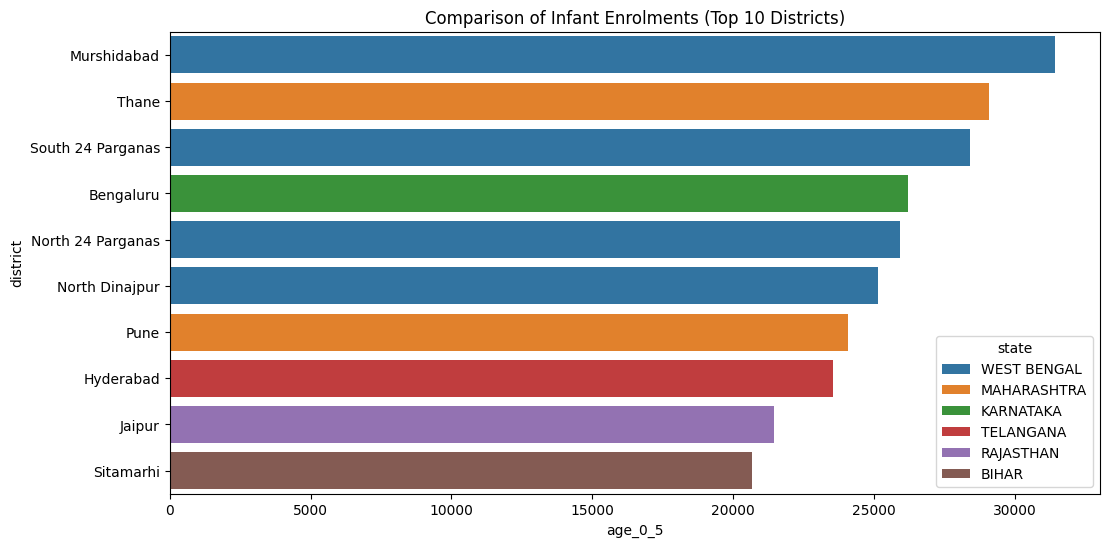

In [27]:
# Aggregate by District and State
district_comparison = enrolment_df.groupby(['state', 'district'])['age_0_5'].sum().reset_index()

# Sort to find Top 10 High-Growth vs. Low-Growth Districts
top_districts = district_comparison.sort_values(by='age_0_5', ascending=False).head(10)

# Visualization: District Comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=top_districts, x='age_0_5', y='district', hue='state')
plt.title("Comparison of Infant Enrolments (Top 10 Districts)")
plt.show()

# Difference: Biometric Updates vs. Initial Enrollment

In [28]:
# Aggregate Bio and Enrolment data by State to allow a clean merge
state_enrol = enrolment_df.groupby('state')['age_5_17'].sum().reset_index()
state_bio = biometric_df.groupby('state')['bio_age_5_17'].sum().reset_index()

# Merge and calculate the "Transition Gap"
bio_comparison = pd.merge(state_enrol, state_bio, on='state')
bio_comparison['gap_ratio'] = bio_comparison['bio_age_5_17'] / bio_comparison['age_5_17']

# A ratio < 1.0 indicates children who enrolled but haven't updated biometrics
print(bio_comparison[['state', 'gap_ratio']].sort_values(by='gap_ratio'))

                                       state   gap_ratio
22                                 MEGHALAYA    0.685320
24                                  NAGALAND    3.271476
4                                      BIHAR    6.595482
3                                      ASSAM    9.028130
35                               WEST BENGAL   11.383524
29                                    SIKKIM   11.396371
33                             UTTAR PRADESH   12.939914
14                                 JHARKHAND   15.235110
28                                 RAJASTHAN   18.269910
2                          ARUNACHAL PRADESH   19.183363
10                                   GUJARAT   20.520005
21                                   MANIPUR   20.671178
17                                    LADAKH   21.120301
8                                      DELHI   24.947838
19                            MADHYA PRADESH   27.496902
16                                    KERALA   34.854169
15                             

# Month-Wise Enrollment Trends

In [29]:
# Convert to datetime objects
enrolment_df['date'] = pd.to_datetime(enrolment_df['date'], dayfirst=True)

# Resample by Month and Plot
monthly_trends = enrolment_df.set_index('date')['age_0_5'].resample('ME').sum().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_trends, x='date', y='age_0_5', marker='o', color='green')
plt.title("Month-wise Infant Enrolment Trends (Seasonal Analysis)")
plt.ylabel("Total New Enrolments")
plt.grid(True)
plt.show()

KeyError: 'date'

# the map shows where vaccination efforts succeeded or failed in the past, 2025 Aadhaar data allows us to predict where those gaps exist right now

Legend Color,Vaccination % (NFHS-5),Risk Level,2025 Proxy Strategy  
Dark Green,80% & Above,Low Risk,High Enrolment Ratio (>0.9)  
Light Green,70% - 80%,Moderate,Enrolment Ratio (0.8 - 0.9)  
Yellow,60% - 70%,High Risk,Enrolment Ratio (0.7 - 0.8)    
Orange/Red,Below 60%,Critical,Low Enrolment Ratio (<0.7)   

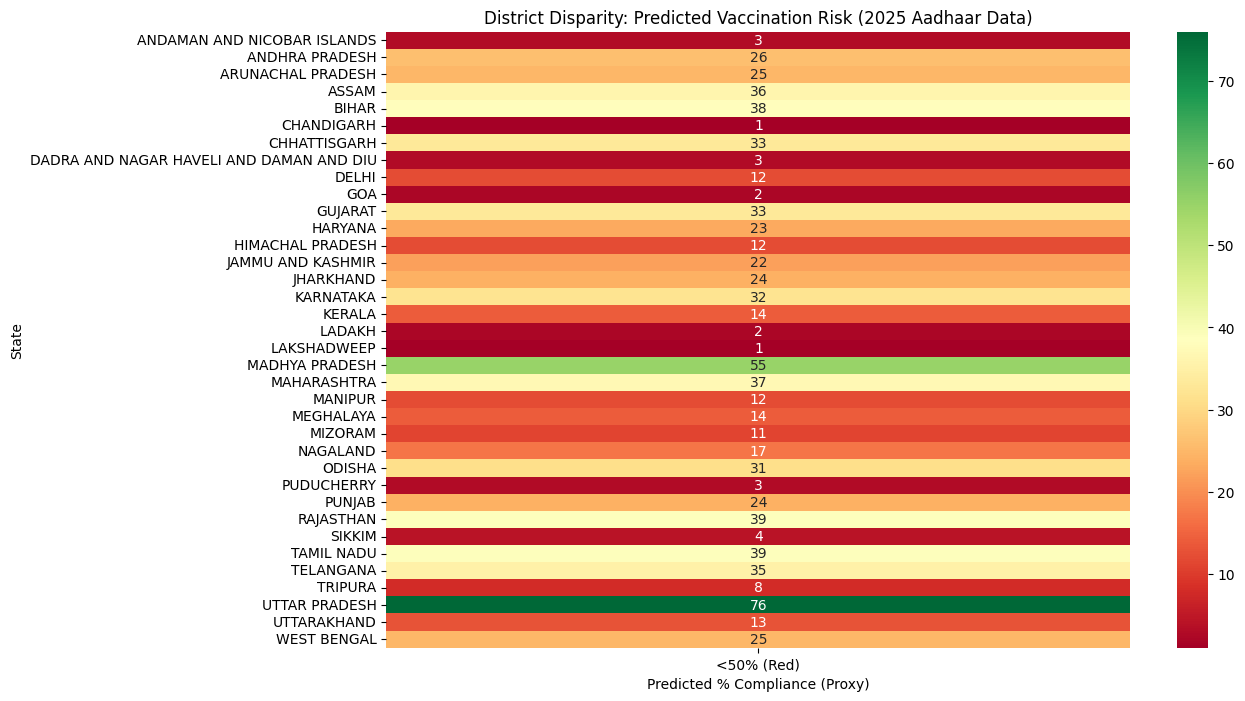

Detected 785 districts in the 'Critical' (Red) zone.


In [30]:
# 1. Calculate the 'Identification Gap' per District
# We assume 'birth_projections' has been mapped down to districts
district_analysis = pd.merge(enrolment_df, birth_projections, on='state')
district_analysis['enrolment_ratio'] = district_analysis['age_0_5'] / district_analysis['estimated number of infants']

# 2. Map Enrolment Ratios to 'Heatmap Levels' (Matching the Map 9.1 Legend)
def map_to_color(ratio):
    if ratio >= 0.8: return '80% & Above (Dark Green)'
    elif ratio >= 0.7: return '70-80% (Light Green)'
    elif ratio >= 0.6: return '60-70% (Yellow)'
    elif ratio >= 0.5: return '50-60% (Orange)'
    else: return '<50% (Red)'

district_analysis['risk_level'] = district_analysis['enrolment_ratio'].apply(map_to_color)

# 3. Create the 'Disparity Table' for the PDF
heatmap_table = district_analysis.groupby(['state', 'risk_level'])['district'].count().unstack().fillna(0)

# 4. Visualize the Disparity (Heatmap)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_table, annot=True, fmt='g', cmap='RdYlGn')
plt.title("District Disparity: Predicted Vaccination Risk (2025 Aadhaar Data)")
plt.xlabel("Predicted % Compliance (Proxy)")
plt.ylabel("State")
plt.show()

# 5. Output the 'Critical' districts to CSV for final intervention
critical_districts = district_analysis[district_analysis['enrolment_ratio'] < 0.6]
print(f"Detected {len(critical_districts)} districts in the 'Critical' (Red) zone.")

# To calculate Infant Density

In [33]:
# Preprocessing: Standardize state names for the merge
# We remove leading/trailing spaces and convert to uppercase for consistency
enrolment_df['state'] = enrolment_df['state'].str.strip().str.upper()
# The 'state/ut' column was already renamed to 'state' in previous steps
birth_projections['state'] = birth_projections['state'].str.strip().str.upper()

# 3. Aggregate Enrolments by State
# Summing infants (age_0_5) to get the total identified population per state
state_enrolment = enrolment_df.groupby('state')['age_0_5'].sum().reset_index()

# 4. Merge with Birth Projections
# We use 'left join' to ensure no Aadhaar data is lost
final_data = pd.merge(state_enrolment, birth_projections,
                      left_on='state', right_on='state', how='left')

# 5. Feature Engineering: Infant Density & Gap
# Density per state (assuming land_area is added from an external source)
# Identification Gap = Projected Births - Actual Aadhaar Enrolments
final_data['id_gap'] = final_data['estimated number of infants'] - final_data['age_0_5']
final_data['enrolment_ratio'] = final_data['age_0_5'] / final_data['estimated number of infants']

print(final_data[['state', 'estimated number of infants', 'age_0_5', 'enrolment_ratio']].head())

                         state  estimated number of infants  age_0_5  \
0  ANDAMAN AND NICOBAR ISLANDS                         4310      478   
1               ANDHRA PRADESH                       813340    99397   
2            ARUNACHAL PRADESH                        26340     1957   
3                        ASSAM                       713280   141235   
4                        BIHAR                      3126030   262871   

   enrolment_ratio  
0         0.110905  
1         0.122208  
2         0.074298  
3         0.198008  
4         0.084091  


# Biometric Quality as a Proxy for "Systemic Neglect"

Objective: Analyze Mandatory Biometric Update (MBU) success at age 5. Districts with low update ratios suggest that parents have "dropped out" of the system, which correlates with missing final booster doses of vaccines



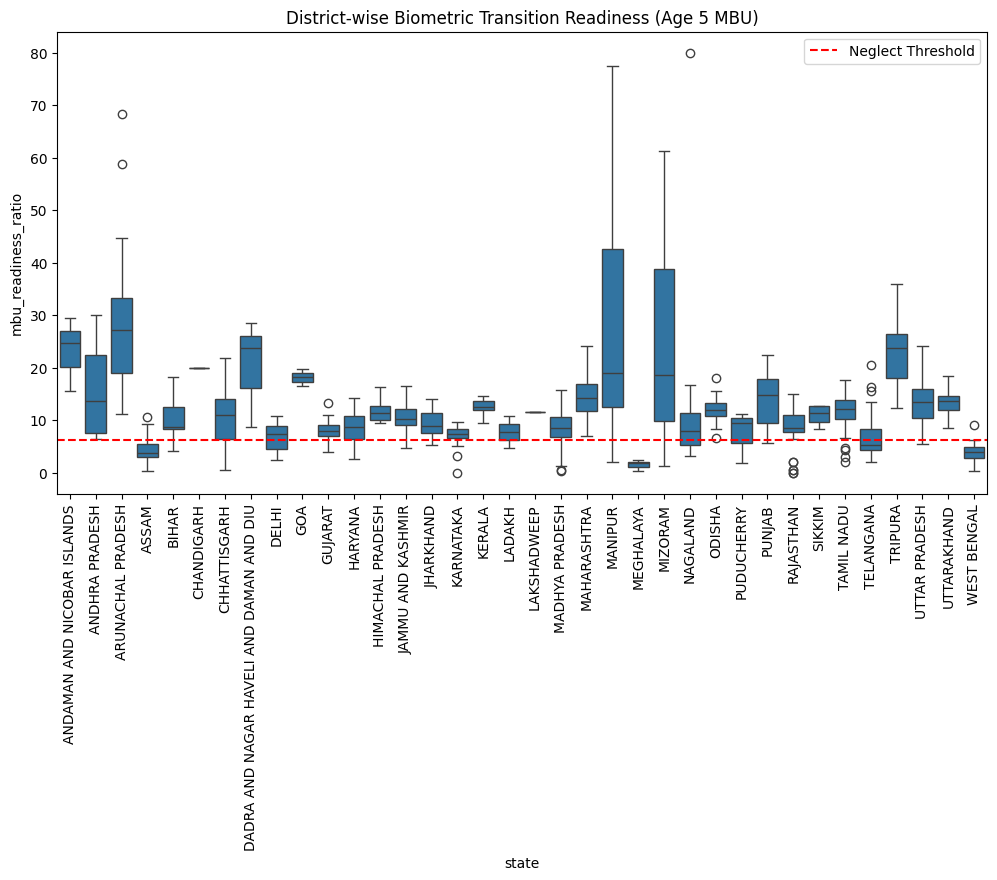

In [37]:
# 1. Calculate the 'Transition Gap' at District Level
# We compare infants (age 0-5) to those returning for MBU (age 5-17)
district_enrol = enrolment_df.groupby(['state', 'district'])['age_0_5'].sum().reset_index()
district_bio = biometric_df.groupby(['state', 'district'])['bio_age_5_17'].sum().reset_index()

# 2. Merge to find the Dropout Rate
transition_analysis = pd.merge(district_enrol, district_bio, on=['state', 'district'])
transition_analysis['mbu_readiness_ratio'] = (transition_analysis['bio_age_5_17'] /
                                               transition_analysis['age_0_5'])

# 3. Label 'Systemic Neglect' Areas
# A ratio < 0.2 indicates that for every 5 infants enrolled, only 1 is returning for MBU
neglect_threshold = transition_analysis['mbu_readiness_ratio'].quantile(0.2)
transition_analysis['neglect_flag'] = transition_analysis['mbu_readiness_ratio'] < neglect_threshold

# 4. Visualize the 'Neglect' clusters
plt.figure(figsize=(12, 6))
sns.boxplot(data=transition_analysis, x='state', y='mbu_readiness_ratio')
plt.xticks(rotation=90)
plt.axhline(neglect_threshold, ls='--', color='red', label='Neglect Threshold')
plt.title("District-wise Biometric Transition Readiness (Age 5 MBU)")
plt.legend()
plt.show()

Y axis - shows the percentage of children who successfully completed their Mandatory Biometric Update (MBU) at age 5 compared to those who initially enrolled as infants.

X axis - states

Red Dashed Line - Any district or state falling below this line is considered at risk for systemic neglect, meaning children in these areas are "falling out" of the digital system and likely missing health services.